In [1]:
import sys
sys.path.append('..')

import numpy as np
import os
from time import time
from collections import Counter
import random
from matplotlib import pyplot as plt

from lib.data_utils import shuffle
#from lib.config import data_dir

def mnist():
    fd = open(os.path.join('train-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trX = loaded[16:].reshape((60000,28*28)).astype(float)

    fd = open(os.path.join('train-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trY = loaded[8:].reshape((60000))

    fd = open(os.path.join('t10k-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teX = loaded[16:].reshape((10000,28*28)).astype(float)

    fd = open(os.path.join('t10k-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teY = loaded[8:].reshape((10000))
    
    trY = np.asarray(trY)
    teY = np.asarray(teY)

    return trX, teX, trY, teY

def mnist_with_valid_set():
    trX, teX, trY, teY = mnist()

    trX, trY = shuffle(trX, trY)
    vaX = trX[50000:]
    vaY = trY[50000:]
    trX = trX[:50000]
    trY = trY[:50000]

    return trX, vaX, teX, trY, vaY, teY

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpyc1lmn/265abc51f7c376c224983485238ff1a5.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpyc1lmn/265abc51f7c376c224983485238ff1a5.exp

Using gpu device 0: Quadro K2000 (CNMeM is disabled, cuDNN 5005)


In [2]:
#data_dir='/home/dcgan_code-master/mnist'
import theano
theano.config.floatX='float32'
theano.config.floatX

'float32'

In [22]:
trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()
import cv2
data2=np.zeros((1000,64*64))
trX=trX
%matplotlib inline
for i in range(1000):
    XXX=trX[i,:].reshape(28,28)
    temp=cv2.resize(XXX,(64,64))
    #temp[temp>=0.5]=1
    #temp[temp<=0.5]=0
    temp=temp.reshape(-1)
    data2[i,:]=np.round(temp/max(temp)*255.)

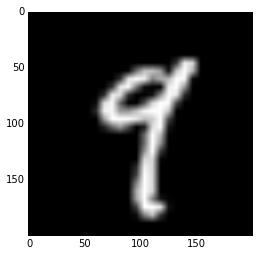

In [79]:
np.set_printoptions(threshold='nan')
plt.imshow(data2[0].reshape(200,200),'gray')
#plt.imshow(trX[0].reshape(28,28),'gray')

In [4]:
import numpy as np
import theano
import theano.tensor as tensor
from theano.tensor.signal.pool import pool_2d
from theano.tensor.nnet import conv2d

def conv( x, w, b=None ):
    s = int(np.floor(w.get_value().shape[-1]/2.))
    z = conv2d(x, w, border_mode='full')[:, :, s:-s, s:-s]
    if b is not None:
        z += b.dimshuffle('x', 0, 'x', 'x')
    
    return z
        
def max_pool( x, size, ignore_border=False ):
    return pool_2d( x, size, ignore_border=ignore_border )

def rectify( x ):
    return (x + abs(x)) / 2.0

def batchnorm( x, g=None, b=None, eps=1e-8 ):
    if x.ndim == 4:
        m = tensor.mean(x, axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')
        v = tensor.mean(tensor.sqr(x - m), 
                          axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')

        x = (x - m) / tensor.sqrt( v + eps )
        if g is not None and b is not None:
            x = x*g.dimshuffle('x', 0, 'x', 'x') + b.dimshuffle('x', 0, 'x', 'x')

    elif x.ndim == 2:
        m = tensor.mean(x, axis=0)
        v = tensor.mean(tensor.sqr(x - m), axis=0)

        x = (x - m) / tensor.sqrt( v + eps )
        if g is not None and b is not None:
            x = x*g + b

    return x

def depool( x, factor=2 ):
    """
    This code is from 
    https://gist.github.com/kastnerkyle/f3f67424adda343fef40
    """
    output_shape = [
        x.shape[1],
        x.shape[2]*factor,
        x.shape[3]*factor
    ]
    stride = x.shape[2]
    offset = x.shape[3]
    in_dim = stride * offset
    out_dim = in_dim * factor * factor

    upsamp_matrix = tensor.zeros((in_dim, out_dim))
    rows = tensor.arange(in_dim)
    cols = rows*factor + (rows/stride * factor * offset)
    upsamp_matrix = tensor.set_subtensor(upsamp_matrix[rows, cols], 1.)

    flat = tensor.reshape(x, (x.shape[0], output_shape[0], x.shape[2] * x.shape[3]))

    up_flat = tensor.dot(flat, upsamp_matrix)
    upsamp = tensor.reshape(up_flat, (x.shape[0], output_shape[0],
                                      output_shape[1], output_shape[2]))

    return upsamp

def full_conn( x, w, b=None ):
    return tensor.dot( x, w ) + b

def leaky_rectify( x, leak=0.2 ):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * abs(x) 

In [12]:
import sys
sys.path.append('..')

import os
import json
from time import time
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.externals import joblib

import theano
import theano.tensor as T
from theano.sandbox.cuda.dnn import dnn_conv

from lib import activations
from lib import updates
from lib import inits
from lib.vis import grayscale_grid_vis
from lib.rng import py_rng, np_rng
from lib.ops import batchnorm, conv_cond_concat, deconv, dropout
from lib.theano_utils import floatX, sharedX
from lib.data_utils import OneHot, shuffle, iter_data
from lib.metrics import nnc_score, nnd_score

trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()
np.set_printoptions(threshold='nan')
#trX=data2
trX = trX[0:1000]
vaX = floatX(vaX[0:1000])/255.

k = 1             # # of discrim updates for each gen update
l2 = 2.5e-5       # l2 weight decay
b1 = 0.5          # momentum term of adam
nc = 1            # # of channels in image
ny = 10           # # of classes
nbatch = 100      # # of examples in batch
npx = 28          # # of pixels width/height of images
nz = 100          # # of dim for Z
ngfc = 1024       # # of gen units for fully connected layers
ndfc = 1024       # # of discrim units for fully connected layers
ngf = 64          # # of gen filters in first conv layer
ndf = 64          # # of discrim filters in first conv layer
nx = npx*npx*nc   # # of dimensions in X
niter = 100       # # of iter at starting learning rate
niter_decay = 100 # # of iter to linearly decay learning rate to zero
lr = 0.0002       # initial learning rate for adam
ntrain, nval, ntest = len(trX), len(vaX), len(teX)

def transform(X):
    return (floatX(X)/255.).reshape(-1, nc, npx, npx)

def inverse_transform(X):
    X = X.reshape(-1, npx, npx)
    return X



relu = activations.Rectify()
sigmoid = activations.Sigmoid()
lrelu = activations.LeakyRectify()
bce = T.nnet.binary_crossentropy

gifn = inits.Normal(scale=0.02)
difn = inits.Normal(scale=0.02)
gain_ifn = inits.Normal(loc=1., scale=0.02)
bias_ifn = inits.Constant(c=0.)

# encoder
ew  = difn((ndf, nc, 5, 5), 'ew')
eg = gain_ifn((ndf), 'eg')
eb = bias_ifn((ndf), 'eb')

ew2 = difn((ndf*2, ndf, 5, 5), 'ew2')
eg2 = gain_ifn((ndf*2), 'eg2')
eb2 = bias_ifn((ndf*2), 'eb2')

ew3 = difn((ndf*2*7*7, ndfc), 'ew3')
eg3 = gain_ifn((ndfc), 'eg3')
eb3 = bias_ifn((ndfc), 'eb3')

bmu = bias_ifn((nz), 'bmu')
wmu = difn((ndf*2*7*7, nz), 'wmu')
bsigma = bias_ifn((nz), 'bsigma')
wsigma = difn((ndf*2*7*7, nz), 'wsigma')

# generate
gw  = gifn((nz, ngfc), 'gw')
gg = gain_ifn((ngfc), 'gg')
gb = bias_ifn((ngfc), 'gb')

gw2 = gifn((ngfc, ngf*2*7*7), 'gw2')
gg2 = gain_ifn((ngf*2*7*7), 'gg2')
gb2 = bias_ifn((ngf*2*7*7), 'gb2')

gw3 = gifn((ngf*2, ngf, 5, 5), 'gw3')
gg3 = gain_ifn((ngf), 'gg3')
gb3 = bias_ifn((ngf), 'gb3')
gwx = gifn((ngf, nc, 5, 5), 'gwx')

# discrim
dw  = difn((ndf, nc, 5, 5), 'dw')

dw2 = difn((ndf*2, ndf, 5, 5), 'dw2')
dg2 = gain_ifn((ndf*2), 'dg2')
db2 = bias_ifn((ndf*2), 'db2')

dw3 = difn((ndf*2*7*7, ndfc), 'dw3')
dg3 = gain_ifn((ndfc), 'dg3')
db3 = bias_ifn((ndfc), 'db3')

dwy = difn((ndfc, 1), 'dwy')

enc_params = [ew, eg, eb, ew2, eg2, eb2, wmu, bmu, wsigma, bsigma]
gen_params = [gw, gg, gb, gw2, gg2, gb2, gw3, gg3, gb3, gwx]
dis_params = [dw,dw2,dg2,db2, dw3,dg3,db3, dwy]

def enc(X, w, eg1, eb1, w2, eg2, eb2, wmu, bmu, wsigma, bsigma):
    h1 = relu(batchnorm(dnn_conv(X, w, subsample=(2, 2), border_mode=(2, 2)),g=eg1, b=eb1))
    h2 = relu(batchnorm(dnn_conv(h1, w2, subsample=(2, 2), border_mode=(2, 2)),g=eg2, b=eb2))
    h3 = T.flatten(h2, 2)
    z_mu = T.dot(h3, wmu) + bmu
    z_log_sigma = 0.5 * (T.dot(h3, wsigma) + bsigma)
    z = z_mu + T.exp(z_log_sigma) 
    return z_mu, z_log_sigma, z

def gen(Z, w, gg, gb, w2, gg2, gb2, w3, gg3, gb3, wx):
    h = relu(batchnorm(T.dot(Z, w),g=gg,b=gb))
    h2 = relu(batchnorm(T.dot(h, w2),g=gg2,b=gb2))
    h2 = h2.reshape((h2.shape[0], ngf*2, 7, 7))
    h3 = relu(batchnorm(deconv(h2, w3, subsample=(2, 2), border_mode=(2, 2)),g=gg3,b=gb3))
    x = sigmoid(deconv(h3, wx, subsample=(2, 2), border_mode=(2, 2)))
    return x

def dis(X, w, w2, dg2, db2, w3, dg3, db3, wy):
    h = lrelu(dnn_conv(X, w, subsample=(2, 2), border_mode=(2, 2)))
    h2 = lrelu(batchnorm(dnn_conv(h, w2, subsample=(2, 2), border_mode=(2, 2)),g=dg2,b=db2))
    feature = h2
    h3 = T.flatten(h2, 2)
    h4 = lrelu(batchnorm(T.dot(h3, w3), g=dg3,b=db3))
    y = sigmoid(T.dot(h4, wy))
    return y, feature

X = T.tensor4()
Z = T.matrix()

encZ_mu,encZ_log_sigma,encZ = enc(X, *enc_params)

from keras import backend as K
epsilon = K.random_normal(shape=(nbatch, nz), mean=0.,
                              std=1)
sampling_Z = encZ_mu + T.exp(encZ_log_sigma / 2) * epsilon

X_tilde = gen(sampling_Z, *gen_params)

Z_rand = K.random_normal(shape=(nbatch, nz), mean=0.,std=1)
X_p = gen(Z_rand, *gen_params)

d_real, xl_real = dis(X, *dis_params)
d_gen, xl_gen = dis(X_tilde, *dis_params)
d_p, xl_p = dis(X_p, *dis_params)

enc_loss_kl = -0.5*T.mean(1+encZ_log_sigma-T.square(encZ_mu)-T.exp(encZ_log_sigma),axis=-1)
enc_loss_sim= T.mean(T.sum((xl_gen-xl_real)**2))

# d_cost_real = bce(p_real, T.ones(p_real.shape)).mean()
# d_cost_gen = bce(p_gen, T.zeros(p_gen.shape)).mean()
# g_cost_d = bce(p_gen, T.ones(p_gen.shape)).mean()

d_cost_real = bce(d_real, T.zeros(d_real.shape)).mean()
d_cost_gen = bce(d_gen, T.ones(d_gen.shape)).mean()
d_cost_p = bce(d_p, T.ones(d_p.shape)).mean()

GAN_loss = (d_cost_real + d_cost_gen + d_cost_p)
enc_cost = T.mean(enc_loss_kl + enc_loss_sim)
gen_cost = 0.1*enc_loss_sim - GAN_loss # paper version
dis_cost = GAN_loss # paper version


cost = [enc_cost,gen_cost,dis_cost]

lrt = sharedX(lr)
enc_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
gen_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
dis_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))

enc_updates = enc_updater(enc_params, enc_cost)
gen_updates = gen_updater(gen_params, gen_cost)
dis_updates = dis_updater(dis_params, dis_cost)

print 'COMPILING'
t = time()

_train_enc = theano.function([X], enc_cost, updates=enc_updates)
_train_gen = theano.function([X,Z_rand,sampling_Z], gen_cost, updates=gen_updates)
_train_dis = theano.function([X,Z_rand,sampling_Z], dis_cost, updates=dis_updates)
_enc = theano.function([X], [encZ_mu, encZ_log_sigma])
_gen = theano.function([sampling_Z], X_tilde)

print '%.2f seconds to compile theano functions'%(time()-t)

sample_zmb = floatX(np_rng.uniform(-1., 1., size=(200, nz)))


n_updates = 0
n_check = 0
n_epochs = 0
n_updates = 0
n_examples = 0

enc_cost_error=[]
gen_cost_error=[]
dis_cost_error=[]
t = time()
iter_error=0
for epoch in range(1, 2000):
    #trX = shuffle(trX)
    for imb in iter_data(trX, size=nbatch):
        imb = transform(imb)
        zmb = floatX(np_rng.uniform(-1., 1., size=(len(imb), nz)))
        
        e_cost = _train_enc(imb)
        
        encZ_mu, encZ_log_sigma = _enc(imb)
        epsilon = np.random.normal(0,1, (nbatch, nz))        
        sampling_Z = encZ_mu + np.exp(encZ_log_sigma / 2) * epsilon
        sampling_Z = sampling_Z.astype(np.float32)
        g_cost = _train_gen(imb,zmb,sampling_Z)        
        d_cost = _train_dis(imb,zmb,sampling_Z)
        
        n_examples += len(imb)

        iter_error += 1
        enc_cost_error.append(e_cost)
        gen_cost_error.append(g_cost)
        dis_cost_error.append(d_cost)
        if (epoch) % 10 == 0:
            print '%.0f %.4f %.4f %.4f'%(epoch, e_cost, g_cost, d_cost)  

COMPILING
54.26 seconds to compile theano functions
10 61878.8203 6045.8848 1.5660
10 63987.5391 6251.3599 1.5702
10 64632.8906 6302.0317 1.5320
10 65891.5781 6432.3667 1.5780
10 63578.9102 6205.7075 1.5603
10 62618.7305 6128.6992 1.5789
10 59838.2031 5831.9302 1.5687
10 60595.6797 5912.1953 1.5549
10 59766.9062 5833.8560 1.5332
10 59880.3281 5835.7134 1.5459
20 31867.7676 3122.9617 1.4240
20 33766.9258 3262.6001 1.4338
20 32556.1230 3155.3225 1.4506
20 33710.3398 3291.2212 1.5422
20 33886.8789 3306.0647 1.4500
20 32777.5703 3188.6536 1.3904
20 30725.5430 3014.8042 1.4526
20 31950.4023 3114.4714 1.4693
20 31774.3008 3121.2681 1.4211
20 31985.3125 3188.5247 1.4507
30 16710.4199 1616.1232 1.4663
30 17105.1328 1601.2841 1.3654
30 16852.8086 1570.2566 1.2885
30 18432.2930 1743.0498 1.3589
30 18613.0195 1708.6821 1.3728
30 17831.2246 1666.6045 1.3343
30 16144.3984 1555.7452 1.3626
30 17196.7344 1563.6315 1.3553
30 16942.7578 1633.5891 1.2889
30 17635.8379 1622.4362 1.3157
40 10706.5059 1013

KeyboardInterrupt: 

In [50]:
lrt.set_value(floatX(0.00000001))
for epoch in range(6870, 100000):
    #trX = shuffle(trX)
    for imb in iter_data(trX, size=nbatch):
        imb = transform(imb)
        zmb = floatX(np_rng.uniform(-1., 1., size=(len(imb), nz)))
        
        e_cost = _train_enc(imb)
        
        encZ_mu, encZ_log_sigma = _enc(imb)
        epsilon = np.random.normal(0,1, (nbatch, nz))        
        sampling_Z = encZ_mu + np.exp(encZ_log_sigma / 2) * epsilon
        sampling_Z = sampling_Z.astype(np.float32)
        g_cost = _train_gen(imb,zmb,sampling_Z)        
        d_cost = _train_dis(imb,zmb,sampling_Z)
        
        n_examples += len(imb)

        iter_error += 1
        enc_cost_error.append(e_cost)
        gen_cost_error.append(g_cost)
        dis_cost_error.append(d_cost)
        if (epoch) % 10 == 0:
            print '%.0f %.4f %.4f %.4f'%(epoch, e_cost, g_cost, d_cost) 

6870 34.1976 1.1084 1.1109
6870 32.2462 0.9942 1.0470
6870 46.5486 2.5816 0.8803
6870 45.7824 2.4318 0.9740
6870 107.0015 8.9634 0.5379
6870 120.4510 10.7268 0.1112
6870 36.5441 1.3651 1.0726
6870 46.3017 2.3968 1.0144
6870 55.8982 3.5694 0.8215
6870 132.5237 11.6455 0.4204
6880 34.1820 1.1076 1.1098
6880 32.2276 0.9987 1.0419
6880 46.5370 2.5845 0.8770
6880 45.7938 2.4278 0.9760
6880 106.9895 8.9613 0.5380
6880 120.4020 10.7236 0.1110
6880 36.4989 1.3657 1.0702
6880 46.3219 2.3958 1.0157
6880 55.9481 3.5703 0.8194
6880 132.4947 11.6363 0.4187
6890 34.2023 1.1087 1.1108
6890 32.2197 0.9973 1.0436
6890 46.5518 2.5770 0.8820
6890 45.7946 2.4304 0.9736
6890 106.9741 8.9657 0.5384
6890 120.4254 10.7288 0.1099
6890 36.5245 1.3690 1.0710
6890 46.3127 2.3957 1.0138
6890 55.9252 3.5689 0.8201
6890 132.4693 11.6411 0.4191
6900 34.2023 1.1065 1.1090
6900 32.2368 0.9941 1.0461
6900 46.5398 2.5822 0.8754
6900 45.7927 2.4341 0.9726
6900 106.9695 8.9639 0.5389
6900 120.4342 10.7243 0.1102
6900 36.52

KeyboardInterrupt: 

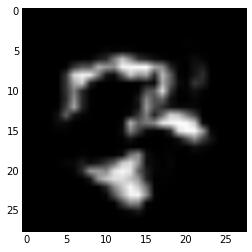

In [51]:
%matplotlib inline
sample_zmb = floatX(np_rng.uniform(-1., 1., size=(100, nz)))
samples = np.asarray(_gen(sample_zmb))
plt.imshow(samples[0].reshape(28,28),'gray')

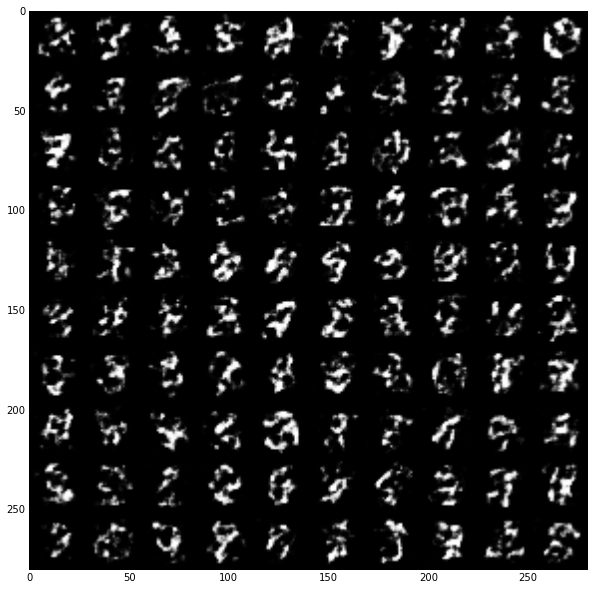

In [53]:
n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np_rng.uniform(-1., 1., size=(100, nz))
        z_sample=z_sample.astype(np.float32)
        x_decoded = _gen(z_sample)[0]
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

(array([ 611.,   16.,   19.,   12.,   14.,    8.,   18.,   23.,   22.,   41.]),
 array([  7.81796072e-10,   9.96440120e-02,   1.99288023e-01,
          2.98932034e-01,   3.98576046e-01,   4.98220057e-01,
          5.97864068e-01,   6.97508079e-01,   7.97152090e-01,
          8.96796101e-01,   9.96440113e-01]),
 <a list of 10 Patch objects>)

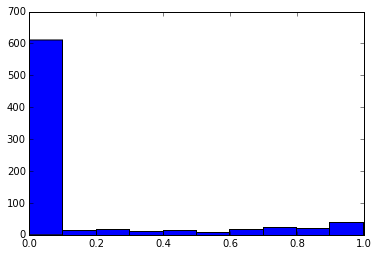

In [45]:
plt.hist(x_decoded.reshape(-1))